# Task 3: Transfer Learning

In [1]:
import importlib
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import src.loading as loading
import src.models as models

importlib.reload(loading)
importlib.reload(models)

<module 'src.models' from 'c:\\Users\\seppe\\AI project\\AI-project\\notebooks\\src\\models.py'>

## 1. Set up the classification

In [2]:
# Choose a metric to evaluate the succes of the classifier.
metrics=['accuracy']

In [3]:
# Set a seed for NumPy and Keras for preproducibility.
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Set up image generators for the training, validation, and test data.
img_height, img_width = 128, 128
batch_size = 32
path = "../data"
train_data_gen, val_data_gen, train_and_val_data_gen, test_data_gen = loading.get_images(path, img_height, img_width, batch_size, norm="training", color_mode="rgb")

Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


## 2. Setup the base model

In [5]:
# Instantiate the base model with the "imagenet" pre-trained weights, not including the top layers.
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

In [6]:
# Freeze all layers in the base model.
base_model.trainable = False

In [7]:
# Add fully connected layers to the base model for the classification task.
model = models.transfer_model(
    base_model,
    dropout_rate = 0.2,
    dense_unit = 512,
    lr =0.001,
    metrics=metrics)

In [8]:
# Print the final architecture.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,343,041 (153.90 MB)

 Trainable params: 16,778,241 (64.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

## 3. Training the model

In [9]:
total_train = train_data_gen.samples
total_val = val_data_gen.samples

print(f"total_train: {total_train}")
print(f"total_val: {total_val}")
print(f"batch_size: {batch_size}")
print(f"steps_per_epoch: {total_train // batch_size}")

total_train: 1600
total_val: 400
batch_size: 32
steps_per_epoch: 50


In [10]:
# Training the model.
epochs = 30

history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 521ms/step - accuracy: 0.7796 - loss: 7.6204 - val_accuracy: 0.7943 - val_loss: 1.9765
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 490ms/step - accuracy: 0.9299 - loss: 0.5079 - val_accuracy: 0.8542 - val_loss: 1.2163
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 491ms/step - accuracy: 0.9518 - loss: 0.2207 - val_accuracy: 0.7630 - val_loss: 2.2524
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 492ms/step - accuracy: 0.9243 - loss: 0.6127 - val_accuracy: 0.8516 - val_loss: 1.5381
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 492ms/step - accuracy: 0.9705 - loss: 0.1730 - val_accuracy: 0.8255 - val_loss: 1.3463
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 488ms/step - accuracy: 0.9739 - loss: 0.1105 - val_accuracy: 0.8203 - val_loss: 1.7308
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 490ms/step - accuracy: 0.9911 - loss: 0.0355 - val_accuracy: 0.8151 - val_loss: 1.6735
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 492ms/step - accuracy: 0.9819 - loss: 0.0987 - val_accu

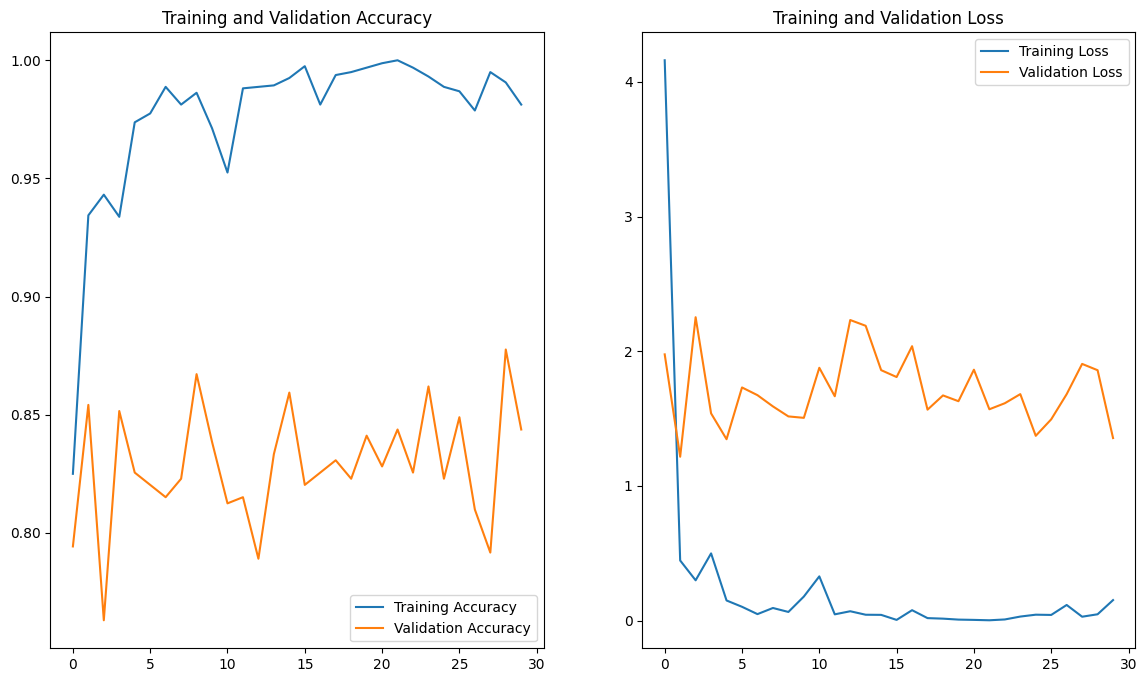

In [11]:
# Plot the model history.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 4. Hyperparameter tuning

In [12]:
# Implement the Keras EarlyStopping callback.
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [13]:
# Hyperparameter options.
batch_sizes = [64, 32]
learning_rates = [0.001, 0.0005]
dropout_rates = [0.1, 0.2, 0.3]

# Create hyperparameter grid.
hyperparameter_grid = list(product(batch_sizes, learning_rates, dropout_rates))

In [14]:
# Rough parameter search.
epochs = 30

total_iterations = len(hyperparameter_grid)
results = []  # List to store results from each run.

print(f"Total iterations: {total_iterations}")

for idx, (batch_size, lr, dropout_rate) in enumerate(hyperparameter_grid):
    print(f"\nRunning: batch_size={batch_size}, learning_rate={lr}, dropout_rate={dropout_rate}")
    
    # Build the model with the current hyperparameters.
    model = models.transfer_model(
    base_model,
    dropout_rate=dropout_rate,
    dense_unit=512,
    lr=lr,
    metrics=metrics)
    
    # Train the model.
    history = model.fit(
        train_data_gen,
        steps_per_epoch=total_train // batch_size,
        epochs=epochs,
        validation_data=val_data_gen,
        validation_steps=total_val // batch_size,
        callbacks=[early_stop],
        verbose=0  # Reduce training output during tuning.
    )
    
    # Find the best validation accuracy and the corresponding epoch.
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    final_val_loss = history.history['val_loss'][best_epoch - 1]
    
    # Append hyperparameters and performance metrics to the results.
    results.append({
        'batch_size': batch_size,
        'learning_rate': lr,
        'dropout_rate': dropout_rate,
        'best_val_accuracy': best_val_acc,
        'best_epoch': best_epoch,
        'final_val_loss': final_val_loss 
    })
    print(f"Completed: best_val_accuracy={best_val_acc:.4f} at epoch {best_epoch}")

    print(idx + 1, "/", total_iterations, end="\r")  # Print progress.

# Move to a new line after the progress bar.
print("\nHyperparameter tuning complete.")

Total iterations: 12

Running: batch_size=64, learning_rate=0.001, dropout_rate=0.1
Completed: best_val_accuracy=0.9688 at epoch 2
1 / 12
Running: batch_size=64, learning_rate=0.001, dropout_rate=0.2
Completed: best_val_accuracy=0.8958 at epoch 6
2 / 12
Running: batch_size=64, learning_rate=0.001, dropout_rate=0.3
Completed: best_val_accuracy=0.9167 at epoch 10
3 / 12
Running: batch_size=64, learning_rate=0.0005, dropout_rate=0.1
Completed: best_val_accuracy=0.8802 at epoch 4
4 / 12
Running: batch_size=64, learning_rate=0.0005, dropout_rate=0.2
Completed: best_val_accuracy=0.9219 at epoch 2
5 / 12
Running: batch_size=64, learning_rate=0.0005, dropout_rate=0.3
Completed: best_val_accuracy=0.9115 at epoch 2
6 / 12
Running: batch_size=32, learning_rate=0.001, dropout_rate=0.1
Completed: best_val_accuracy=0.8646 at epoch 4
7 / 12
Running: batch_size=32, learning_rate=0.001, dropout_rate=0.2
Completed: best_val_accuracy=0.8542 at epoch 5
8 / 12
Running: batch_size=32, learning_rate=0.001, d

In [15]:
# Create a DataFrame from the results and save to CSV.
df_results = pd.DataFrame(results)
csv_filename = "../results/hyperparameter_tuning_results_transfer.csv"
df_results.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

Results saved to ../results/hyperparameter_tuning_results_transfer.csv


## 5. Train pre-trained model

In [16]:
# Select the best configuration based on highest validation accuracy.
results_csv = "../results/hyperparameter_tuning_results_transfer.csv"
df_results = pd.read_csv(results_csv)

best_config = df_results.sort_values('best_val_accuracy', ascending=False).iloc[0]
best_batch_size = int(best_config['batch_size'])
best_lr = best_config['learning_rate']
best_dropout = best_config['dropout_rate']

print("Best Hyperparameters:")
print(best_config)

Best Hyperparameters:
batch_size           64.000000
learning_rate         0.001000
dropout_rate          0.100000
best_val_accuracy     0.968750
best_epoch            2.000000
final_val_loss        0.240565
Name: 0, dtype: float64


In [17]:
# Final model
best_model = models.transfer_model(
    base_model,
    dropout_rate=best_dropout,
    dense_unit=512,
    lr=best_lr,
    metrics=metrics)

best_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4, 4, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,343,041 (153.90 MB)

 Trainable params: 16,778,241 (64.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [18]:
total_train_and_val = train_and_val_data_gen.samples

print(f"total_train_and_val: {total_train_and_val}")
print(f"batch_size: {best_batch_size}")
print(f"steps_per_epoch: {total_train_and_val // best_batch_size}")

total_train_and_val: 2000
batch_size: 64
steps_per_epoch: 31


In [19]:
# Retraining the model using the complete training dataset (including the validation dataset).
epochs_full = 2

history_full = best_model.fit(
    train_and_val_data_gen,
    batch_size=best_batch_size,
    steps_per_epoch=total_train_and_val // best_batch_size,
    epochs=epochs_full,
)

Epoch 1/2
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 435ms/step - accuracy: 0.6346 - loss: 19.1341
Epoch 2/2
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 429ms/step - accuracy: 0.7777 - loss: 0.4595


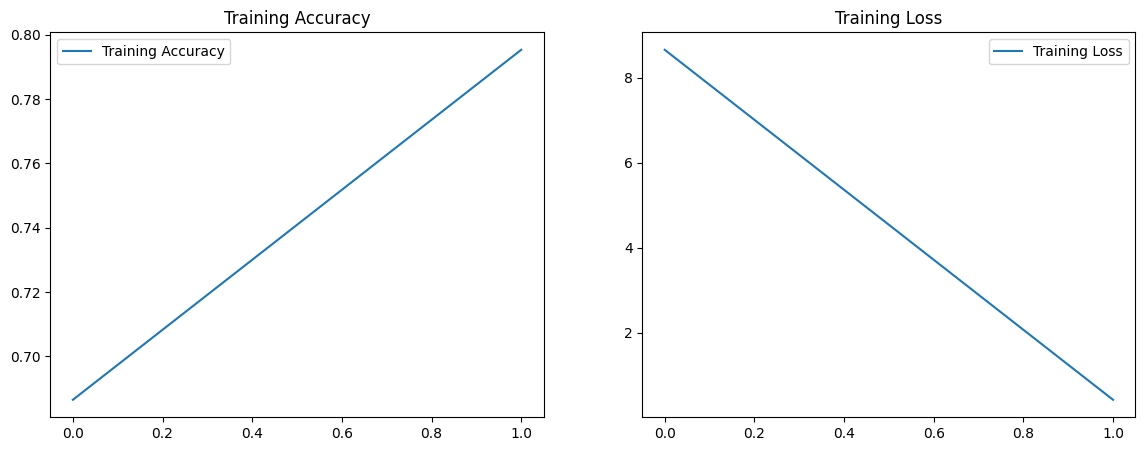

In [20]:
# Retrieve only the training history.
acc = history_full.history['accuracy']
loss = history_full.history['loss']
epochs_range = range(epochs_full)

# Plot only the training curves.
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.title('Training Loss')
plt.legend()

plt.show()

In [21]:
# Save the retrained model to disk.
model_save_path = "../results/final_transfer.keras"

best_model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to ../results/final_transfer.keras


In [22]:
# Reload the model from disk.
reloaded_model = load_model(model_save_path)
print("Model loaded from disk.")

Model loaded from disk.


In [27]:
# Evaluate the reloaded model on the test set.
test_loss, test_accuracy = reloaded_model.evaluate(
    test_data_gen,
    verbose=1,
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step - accuracy: 0.8039 - loss: 0.4567
Test Loss: 0.4483
Test Accuracy: 0.7600


In [28]:
# Generate predictions on the entire test set.
predictions = reloaded_model.predict(
    test_data_gen, 
    verbose=1
)

# For binary classification, use a threshold of 0.5.
predictions_class = (predictions >= 0.5).astype(int).flatten()

# Get ground truth labels from the generator.
true_labels = test_data_gen.classes

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step


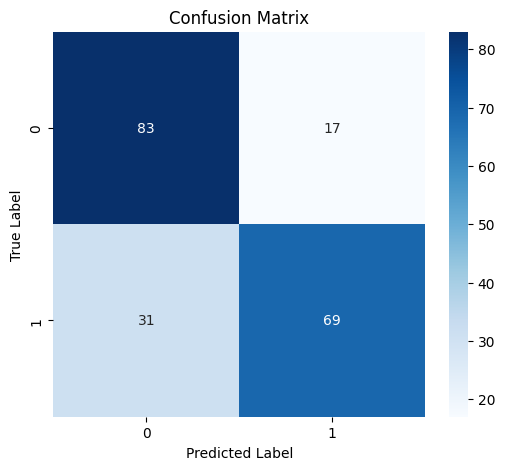

In [29]:
# Compute the confusion matrix.
cm = confusion_matrix(true_labels, predictions_class)

# Plot the confusion matrix.
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


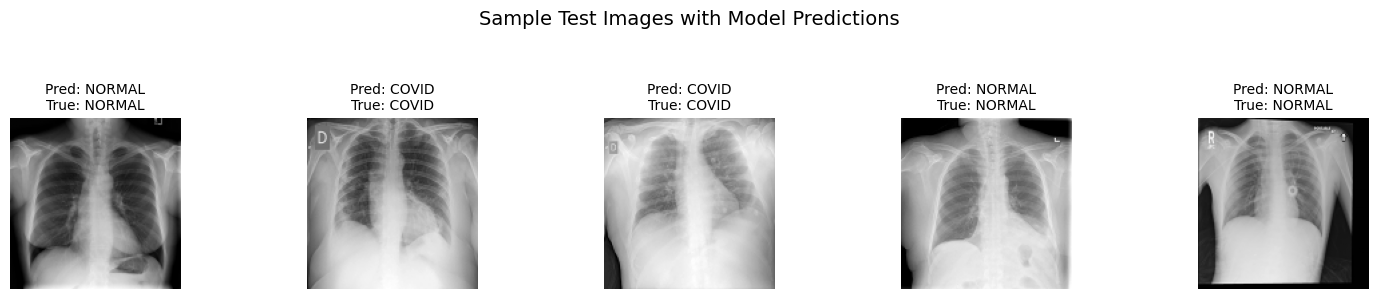

In [30]:
# Create a test data generator WITHOUT normalization (for displaying original images).
_, _, _, test_data_gen_no_norm = loading.get_images(
    path, 
    img_height, 
    img_width, 
    batch_size)

images, _, labels = loading.generator_to_array(test_data_gen_no_norm)

# Plot a few sample images with the predicted labels.
num_images_to_plot = 5
images_to_plot = random.sample(range(total_test), num_images_to_plot)
plt.figure(figsize=(15, 3))
for i, idx in enumerate(images_to_plot):
    plt.subplot(1, num_images_to_plot, i+1)
    # Display the original (non-normalized) image.
    plt.imshow(images[idx].astype("uint8"), cmap="gray")
    
    true_label = labels[idx]
    pred_label = test_data_gen.class_names[predictions_class[idx]]
    
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=10)
    plt.axis('off')
plt.suptitle("Sample Test Images with Model Predictions", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.85])  # Leave space for suptitle
plt.show()

# Fine-tuning the entire model

In [67]:
# Unfreeze part of the base model.
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

best_model_fine_tuned = models.transfer_model(
    base_model,
    dropout_rate=best_dropout,
    dense_unit=512,
    lr=0.0005, # Can be changed
    metrics=metrics)

best_model_fine_tuned.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 4, 4, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,343,041 (153.90 MB)

 Trainable params: 20,194,305 (77.04 MB)

 Non-trainable params: 20,148,736 (76.86 MB)

In [68]:
# Retrain the whole model.
epochs_full = 2

history_full = best_model_fine_tuned.fit(
    train_and_val_data_gen,
    batch_size=best_batch_size,
    steps_per_epoch=total_train_and_val // best_batch_size,
    epochs=epochs_full,
)

Epoch 1/2
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 528ms/step - accuracy: 0.7486 - loss: 0.8134
Epoch 2/2
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 517ms/step - accuracy: 0.8389 - loss: 0.3911


How do you even evaluate a drop in performance on the training dataset if the loss/accuracy always decreases/increases? Currently I made the next questions for both models (see previous section), the fine tuned version performs worse. Normally we are only allowed to use the test set once at the end but I see no other way to evaluate.

In [69]:
# Save the retrained model to disk.
model_save_path = "../results/final_transfer_fine_tuned.keras"

best_model_fine_tuned.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to ../results/final_transfer_fine_tuned.keras


In [70]:
# Reload the model from disk.
reloaded_model = load_model(model_save_path)
print("Model loaded from disk.")

Model loaded from disk.


In [71]:
# Evaluate the reloaded model on the test set.
test_loss, test_accuracy = reloaded_model.evaluate(
    test_data_gen, 
    verbose=1,
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step - accuracy: 0.8530 - loss: 0.8704
Test Loss: 1.4420
Test Accuracy: 0.7550


In [72]:
# Generate predictions on the entire test set.
predictions = reloaded_model.predict(
    test_data_gen, 
    verbose=1
)

# For binary classification, use a threshold of 0.5.
predictions_class = (predictions >= 0.5).astype(int).flatten()

# Get ground truth labels from the generator.
true_labels = test_data_gen.classes

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 498ms/step


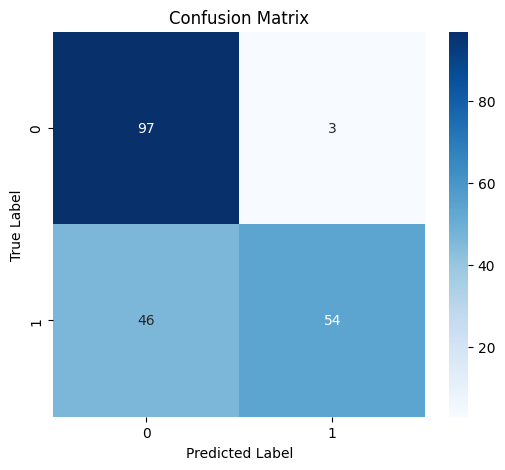

In [73]:
# Compute the confusion matrix.
cm = confusion_matrix(true_labels, predictions_class)

# Plot the confusion matrix.
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


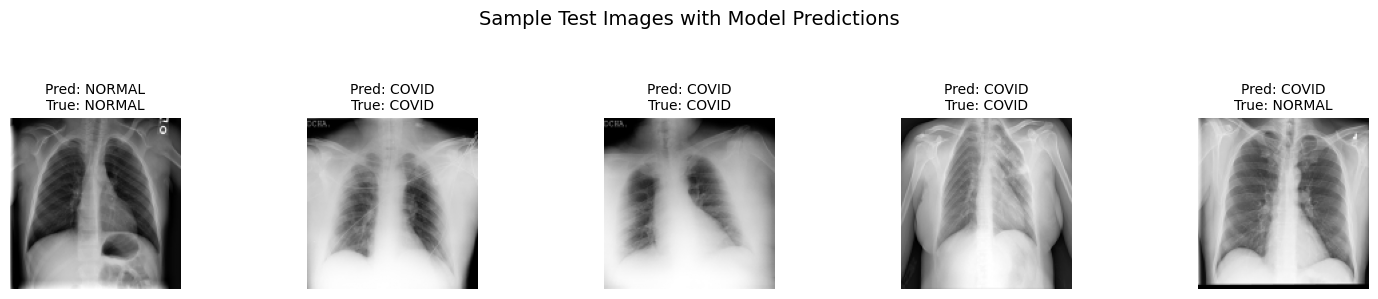

In [36]:
# Create a test data generator WITHOUT normalization (for displaying original images).
_, _, _, test_data_gen_no_norm = loading.get_images(
    path, 
    img_height, 
    img_width, 
    batch_size)

images, _, labels = loading.generator_to_array(test_data_gen_no_norm)

# Plot a few sample images with the predicted labels.
num_images_to_plot = 5
images_to_plot = random.sample(range(total_test), num_images_to_plot)
plt.figure(figsize=(15, 3))
for i, idx in enumerate(images_to_plot):
    plt.subplot(1, num_images_to_plot, i+1)
    # Display the original (non-normalized) image.
    plt.imshow(images[idx].astype("uint8"), cmap="gray")
    
    true_label = labels[idx]
    pred_label = test_data_gen.class_names[predictions_class[idx]]
    
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=10)
    plt.axis('off')
plt.suptitle("Sample Test Images with Model Predictions", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.85])  # Leave space for suptitle
plt.show()